[INFO] Recalculating Recall...


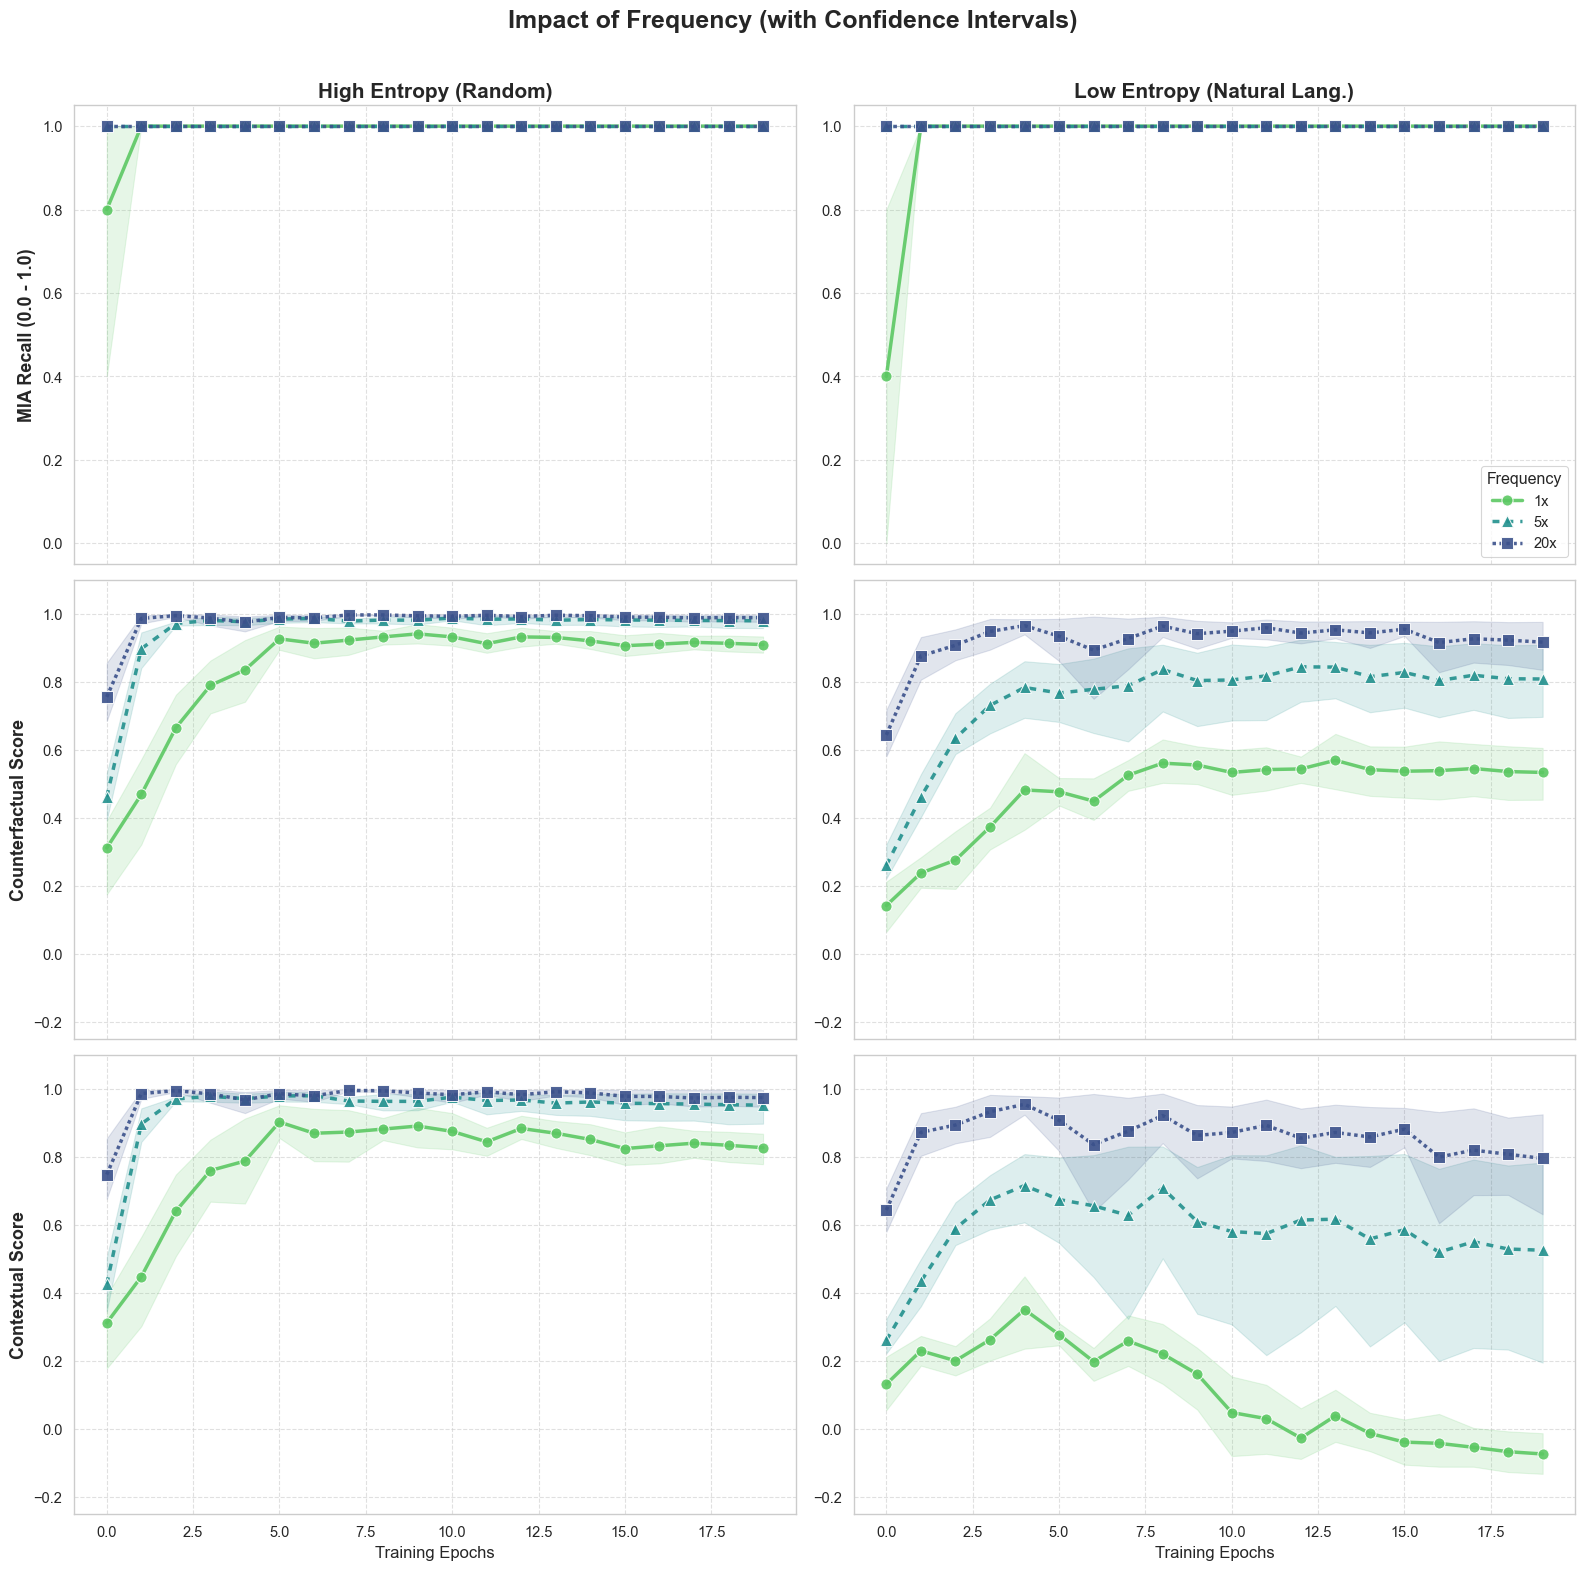

Graph saved as 'frequency_plot_ci.png'


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
RESULTS_PATH = "wikipedia/experiments/run_20251216_155522/results/canary_details_full.csv"
CANARIES_PATH = "memorization/canaries.csv"

# ==============================================================================
# 2. HELPER: CALCULATE RECALL (0-1)
# ==============================================================================
def calculate_recall_dynamic(df):
    df = df.copy()
    df['is_memorized'] = 0 
    for epoch in df['epoch'].unique():
        for ent_type in df['Entropy Type'].unique():
            subset_mask = (df['epoch'] == epoch) & (df['Entropy Type'] == ent_type)
            val_scores = df.loc[subset_mask & (df['split_y'] == 'validation'), 'mia_score']
            
            if len(val_scores) > 0:
                threshold = np.percentile(val_scores, 90) # 10% FPR
                train_mask = subset_mask & (df['split_y'] == 'train')
                df.loc[train_mask, 'is_memorized'] = (df.loc[train_mask, 'mia_score'] > threshold).astype(int)
    return df

# ==============================================================================
# 3. DATA LOADING
# ==============================================================================
if not os.path.exists(RESULTS_PATH) or not os.path.exists(CANARIES_PATH):
    print("[ERROR] Files not found.")
else:
    df_results = pd.read_csv(RESULTS_PATH)
    df_config = pd.read_csv(CANARIES_PATH)
    
    # Merge
    df_config_clean = df_config[['canary_id', 'repetitions', 'type', 'split']]
    merged_df = pd.merge(df_results, df_config_clean, on='canary_id', how='left')

    # Formatting
    merged_df['Entropy Type'] = merged_df['type'].apply(
        lambda x: 'High Entropy (Random)' if 'high' in x else 'Low Entropy (Natural Lang.)'
    )
    merged_df['Repetitions'] = merged_df['repetitions'].astype(str) + "x"
    
    sort_order = ["1x", "5x", "20x"]
    merged_df['Repetitions'] = pd.Categorical(merged_df['Repetitions'], categories=sort_order, ordered=True)

    # Recalculate MIA Recall
    print("[INFO] Recalculating Recall...")
    merged_df = calculate_recall_dynamic(merged_df)

    # FILTER TRAIN ONLY
    plot_df = merged_df[merged_df['split_y'] == 'train'].copy()

    # ==============================================================================
    # 4. PLOTTING WITH ERROR BARS
    # ==============================================================================
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    markers_dict = {"1x": "o", "5x": "^", "20x": "s"}
    dashes_dict = {"1x": "", "5x": (2, 2), "20x": (1, 1)} 
    palette = sns.color_palette("viridis_r", 3)

    fig, axes = plt.subplots(3, 2, figsize=(16, 16), sharex=True)

    metrics_config = [
        ('is_memorized', 'MIA Recall (0.0 - 1.0)'),
        ('counterfactual_score', 'Counterfactual Score'),
        ('contextual_score', 'Contextual Score')
    ]

    for i, (metric_col, metric_name) in enumerate(metrics_config):
        for j, entropy_type in enumerate(['High Entropy (Random)', 'Low Entropy (Natural Lang.)']):
            
            ax = axes[i, j]
            data_subset = plot_df[plot_df['Entropy Type'] == entropy_type]
            
            sns.lineplot(
                data=data_subset,
                x='epoch', y=metric_col,
                hue='Repetitions',
                style='Repetitions',
                markers=markers_dict,
                dashes=dashes_dict,
                palette=palette,
                ax=ax,
                linewidth=2.5,
                markersize=8,
                alpha=0.9,
                # --- QUESTA È LA PARTE CHIAVE ---
                errorbar=('ci', 95),       # Attiva intervallo confidenza 95%
                err_kws={'alpha': 0.15}    # Molto trasparente per non coprire
                # --------------------------------
            )
            
            if i == 0: ax.set_title(f"{entropy_type}", fontsize=15, fontweight='bold')
            if j == 0: ax.set_ylabel(metric_name, fontsize=13, fontweight='bold')
            else: ax.set_ylabel("")

            # Limits
            if metric_col == 'is_memorized':
                ax.set_ylim(-0.05, 1.05)
            else:
                ax.set_ylim(-0.25, 1.1)

            ax.grid(True, linestyle='--', alpha=0.6)
            
            if i == 0 and j == 1:
                ax.legend(title="Frequency", loc='lower right', frameon=True)
            else:
                if ax.get_legend() is not None: ax.get_legend().remove()

    axes[2, 0].set_xlabel("Training Epochs", fontsize=12)
    axes[2, 1].set_xlabel("Training Epochs", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Impact of Frequency (with Confidence Intervals)", fontsize=18, fontweight='bold')

    plt.show()
    fig.savefig("frequency_plot_ci.png", dpi=300, bbox_inches='tight')
    print("Graph saved as 'frequency_plot_ci.png'")